L'objectif de ce Notebook est d'implémenter le modèle cycleGAN en s'aidant entre autre du papier disponible à cette adresse : https://junyanz.github.io/CycleGAN/. Pour cela, nous nous sommes aidés du schéma d'implémentation de Paul Vicol de l'Université de Toronto (http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/assignments/assignment4.pdf). Le modèle a été implémenté en utilisant le module $\textit{tensorflow}$. 

# 0. Description du modèle et organisation du Notebook

## 0.a Description du modèle 



Le modèle CycleGan est un modèle de réseau de neuronnes constitué de 2 générateurs et de 2 discriminateurs. Chacun de ces élément est un réseau de neuronnes. Chaque couple (générateur,discriminateur) a pour objectif de ‘convertir' une image d'un espace dans un autre espace (1 -> 2 et 2 ->1) . Nous noterons respectivement les couples associés aux transformations 1 -> 2 et 2 ->1  ($G_{1},D_{1}$) et ($G_{2},D_{2}$). Notons que l'architecture des deux couples est identique.

$\underline{générateur}$ 

Le générateur est initialement constitué de 3 parties distinctes (selon le papier de Paul Vicol) : l'encodeur, le transformeur et le décodeur.

L'encodeur consiste en une succession de convolutions (une ou plusieurs). Selon le papier ‘Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks', 3 couches sont considérées.

Le transformeur est constitué de blocs appelés $\textit{residual blocks}$. Chacun de ces blocks est constitué de 2 couches de convolutions puis d'une opération d'addition entre l'input du block et l'output. L'article source considère 6  $\textit{residual blocks}$. 

Le décodeur est un block constitué d'opérations de ‘déconvolution' suivies de convolutions classiques. L'opération de ‘déconvolution' correspond en réalité à une convolution mais en ajoutant des zéros (pour cette raison appelée ‘fractional-strided-Convolution' dans l'article) à l'image initiale.

Il suffit désormais d'assembler ces trois fonctions pour creer ce qui sera le générateur (1 ou 2).

$\underline{discriminateur}$

Dans l'article référence, le discriminateur (1 ou 2) est un réseau de neuronnes à 4 couches de convolutions.

$\underline{loss}$

Dans ce modèle, nous avons besoin de définir trois pertes :
- la $\textit{loss}$ associée aux discriminateurs : 

$(\textit{E}_{x \sim data_1}[D_{2}(G_{1}(x))^{2}] + \textit{E}_{y \sim data_2}[(D_{2}(y)-1)^{2}])/2 $ et $(\textit{E}_{x \sim data_2}[D_{1}(G_{2}(x))^{2}] + \textit{E}_{y \sim data_1}[(D_{1}(y)-1)^{2}])/2 $

L'objectif du discriminateur est de minimiser cette perte.

- la $\textit{loss}$ associée aux générateurs : 

$\textit{E}_{x \sim data_1}[D_{2}(G_{1}(x)-1)^{2}] + \textit{E}_{y \sim data_2}[(D_{2}(y))^{2}] $ et $\textit{E}_{y \sim data_2}[D_{1}(G_{2}(y)-1)^{2}] + \textit{E}_{x \sim data_1}[(D_{1}(x))^{2}] $

L'objectif du générateur est de minimiser cette perte.

- la $\textit{loss}$ associée au cycle ($\textit{Cycle Consistency Loss}$)

$\textit{E}_{x \sim data_1}[||G_{2}(G_{1}(x)-x||_{L1}] + \textit{E}_{y \sim data_2}[||G_{1}(G_{2}(y)-y||_{L1}] $

Cette $\textit{loss}$ a pour objectif de vérifier que le générateur 1 -> 2 est bien la réciproque du générateur permettant 2 -> 1.

L'objectif est donc de minimiser ces pertes. La perte cyclique est injectée dans la perte associée au générateur avec un facteur 10 (pour l'amplifier, $\lambda$ dans l'article).

$\underline{aprentissage}$

Concernant la méthode d'apprentissage, l'article source considère 200 epochs. Les 100 premières epochs ont un $\textit{learning rate}$ fixé à 0.0002 pour les 100 premières epochs, puis décroit linéairement vers 0 pour les 100 dernières epochs. 

## O.b Plan du Notebook

Notre implémentation se divise en 2 parties : 

1. Import des constantes et des bases de données 
    * 1.a Import des constantes
    * 1.b import des bases de données et visualisation



2. Implémentation d'un modèle simplifié de CycleGan 
    * 2.a Construction du modèle et du processus d'apprentissage
    * 2.b CycleGan simplifié sur des images de fonds noirs
    * 2.c CycleGan simplifié sur des images de fonds noirs et blancs


# 1. Import des constantes et des bases de données 

## 1.a Import des constantes

In [50]:
# Packages
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
from PIL import Image
import numpy as np
import mlxtend
from mlxtend.data import loadlocal_mnist
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings("ignore")

#Import du repositery github contenant les bases et les sauvegardes des modèles 
!pip install gitpython
import git
import zipfile

try:
  git.Git("sample_data").clone("git://github.com/salimYOU/Deep_GAN.git")
  ##exctraction de la base de train sur MNIST
  with zipfile.ZipFile("sample_data/Deep_GAN/train_images_MNIST.zip","r") as zip_ref:
    zip_ref.extractall("sample_data/Deep_GAN/train_images_MNIST_folder")
except : pass


#tf.__version__

######################################################################
######################################################################

# fonctions pour plotter les résultats et les images initiales 

def print_results(folder_models,iteration_model_toplot,number_toplot,base_MINST,base_USPS,fond=True):
    
    fig, axarr = plt.subplots(2,2)
    fig.tight_layout()
    
    ## MINST intiale et MINST générée
    matrix_pixels=base_MINST[dic_index_MINST[str(number_toplot)]]
    axarr[0,0].imshow(matrix_pixels,cmap='gray')
    x=axarr[0,0].set_title('{} de la base MINST'.format(number_toplot))
    
    picklefile = open('sample_data/Deep_GAN/{}/model_{}iter'.format(folder_models,iteration_model_toplot), 'rb')
    model_touse = pickle.load(picklefile)
    picklefile.close()
    matrix_pixels = base_MINST[[dic_index_MINST[str(number_toplot)]], :, :, np.newaxis]
    results=model_touse.generateur_2(matrix_pixels)
    if fond:
      results=1-results[0,:,:,0]
    else : 
      results=results[0,:,:,0]
    axarr[0,1].imshow(results,cmap='gray')
    y=axarr[0,1].set_title('-> transformé en USPS'.format(number_toplot))
    
    ## USPS intiale et USPS générée
    matrix_pixels=base_USPS[dic_index_USPS[str(number_toplot)]]
    axarr[1,0].imshow(matrix_pixels,cmap='gray')
    x=axarr[1,0].set_title('{} de la base USPS'.format(number_toplot))
    
    picklefile = open('sample_data/Deep_GAN/{}/model_{}iter'.format(folder_models,iteration_model_toplot), 'rb')
    model_touse = pickle.load(picklefile)
    picklefile.close()
    matrix_pixels = base_USPS[[dic_index_USPS[str(number_toplot)]], :, :, np.newaxis]
    results=model_touse.generateur_1(matrix_pixels)
    if fond:
      results=1-results[0,:,:,0]
    else : 
      results=results[0,:,:,0]
    axarr[1,1].imshow(results,cmap='gray')
    y=axarr[1,1].set_title('-> transformé en MINST'.format(number_toplot))
    
    
def print_data_vize(number_toplot,base_image_Mn,base_image_Up):

    fig, axarr = plt.subplots(1,2)
    matrix_pixels=base_image_Mn[dic_index_MINST[str(number_toplot)]]
    axarr[0].imshow(np.round(matrix_pixels, 2),cmap='gray')
    axarr[0].set_title('{} de la base MNIST'.format(number_toplot))
    matrix_pixels=base_image_Up[dic_index_USPS[str(number_toplot)]]
    axarr[1].imshow(np.round(matrix_pixels, 2),cmap='gray')
    axarr[1].set_title('{} de la base USPS'.format(number_toplot))
    

## 1.b Import des bases de données et visualisation

Nous avons considéré les bases d'images MNIST et USPS qui sont constituées des chiffres allant de 0 à 9. L'objectif est d'arriver à convertir le ‘style' d'une base en le ‘style' de l'autre. Les données USPS étant des images de tailles 16$\times$16, nous les avons redimensionneer 28$\times$28 pour les faire correspondre aux données MNIST.

In [0]:
#Import des bases 

################################################
################################################

# Import du dataset MINST

train_image_Mn,train_label_Mn=loadlocal_mnist(images_path='sample_data/Deep_GAN/train_images_MNIST_folder/train_images_MNIST',labels_path='sample_data/Deep_GAN/train_labels_MINST')
test_image_Mn,test_label_Mn=loadlocal_mnist(images_path='sample_data/Deep_GAN/test_images_MNIST',labels_path='sample_data/Deep_GAN/test_labels_MINST')

train_image_Mn=train_image_Mn.reshape((train_image_Mn.shape[0],28, 28))
test_image_Mn=test_image_Mn.reshape((test_image_Mn.shape[0],28, 28))
## Normalisation
train_image_Mn_new=[np.round(train_image_Mn[k]/255,2) for k in range(len(train_image_Mn))]
train_image_Mn=np.array(train_image_Mn_new)

## Normalisation des images MNIST
test_image_Mn=[np.round(test_image_Mn[k]/255,2) for k in range(len(test_image_Mn))]
test_image_Mn=np.array(test_image_Mn)

################################################
################################################

# Import du dataset USPS

f = h5py.File('sample_data/Deep_GAN/usps_data.h5', 'r')
test_image_Up = f['test']['data'].value
train_image_Up = f['train']['data'].value

#Reformatage des données 16*16 --> 28*28
train_image_Up_new=[]
train_image_Up_old=train_image_Up.reshape((train_image_Up.shape[0],16,16))
for array in train_image_Up_old:
    img_pil = Image.fromarray(array)
    img_28x28=img_pil.resize((28, 28),Image.ANTIALIAS)
    array_28x28=np.asarray(img_28x28)
    train_image_Up_new.append(array_28x28)
train_image_Up=np.array(train_image_Up_new)


test_image_Up_new=[]
test_image_Up_old=test_image_Up.reshape((test_image_Up.shape[0],16,16))
for array in test_image_Up_old:
    img_pil = Image.fromarray(array)
    img_28x28=img_pil.resize((28, 28),Image.ANTIALIAS)
    array_28x28=np.asarray(img_28x28)
    test_image_Up_new.append(array_28x28)
test_image_Up=np.array(train_image_Up_new)

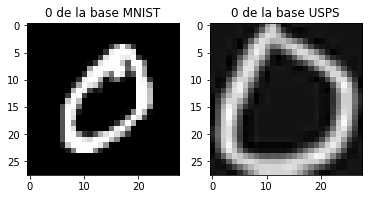

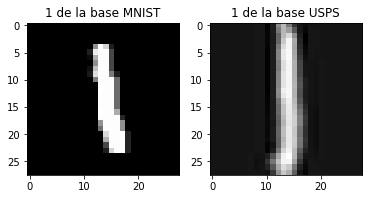

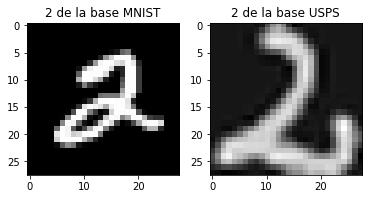

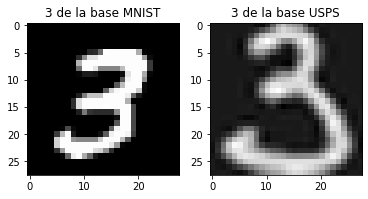

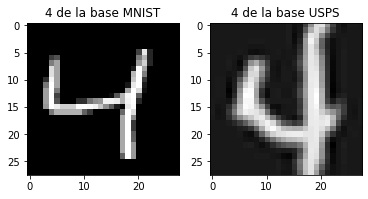

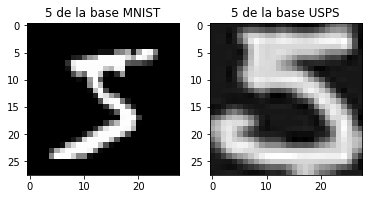

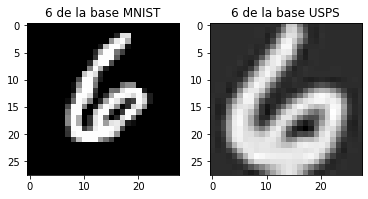

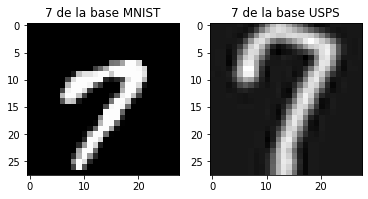

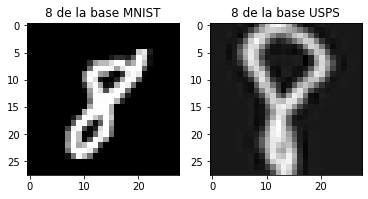

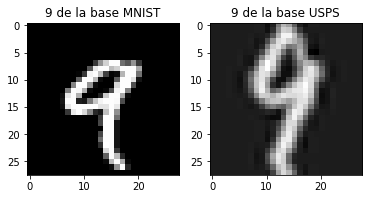

In [52]:
### Visualisation des données

##indice des chiffres à plotter
dic_index_MINST={'0':1,'1':6,'2':5,'3':7,'4':2,'5':0,'6':13,'7':15,'8':17,'9':4}
dic_index_USPS={'0':8,'1':7,'2':41,'3':4,'4':2,'5':1,'6':0,'7':3,'8':54,'9':64}

for number_toplot in range(10):
    print_data_vize(number_toplot,train_image_Mn,train_image_Up)


# 2. Implémentation d'un modèle simplifié de CycleGan 

L'objectif de cette section est d'implémenter un CycleGan largement simplifié par rapport à son implémentation initiale. 

Principalement, cela revient à simplifier l'architecture 'encodeur-transformeur-décodeur' des générateurs. Chaque générateur n'est plus que constitué de 3 couches. 

La fonction de perte est identique à celle décrite dans le papier initiale. 

## 2.a Construction du modèle et du processus d'apprentissage

In [0]:
# Construction du modèle via la classe 'Model'

class Model(object):
    
    #Définition des variables du réseau 
    
    def __init__(self):
        ## Variables du premier générateur
        self.G1_W1 = tf.Variable(np.random.randn(3,3,1,8), shape=[3,3,1,8], trainable=True, name="G1_W1")
        
        #### (On initialise la première variable de poids avec np.random.randn(3,3,1,8), en fixant
        #### en fixant sa taille à (3,3,1,8). On la nomme G1_W1)
        
        self.G1_bias1 = tf.Variable(np.zeros((8)), shape=(8), trainable=True, name="G1_bias1")
        self.G1_W2 = tf.Variable(np.random.randn(3,3,8,4), shape=[3,3,8,4],name="G1_W2")
        self.G1_bias2 = tf.Variable(np.zeros((4)), shape=(4),name="G1_bias2")
        self.G1_W3 = tf.Variable(np.random.randn(3,3,4,1), shape=[3,3,4,1],name="G1_W3")
        self.G1_bias3 = tf.Variable(np.zeros((1)), shape=(1),name="G1_bias3")
        
        ##########################################
        
        ## Variables du deuxième générateur
        self.G2_W1 = tf.Variable(np.random.randn(3,3,1,8), shape=[3,3,1,8], trainable=True, name="G2_W1")
        self.G2_bias1 = tf.Variable(np.zeros((8)), shape=(8), trainable=True, name="G2_bias1")
        self.G2_W2 = tf.Variable(np.random.randn(3,3,8,4), shape=[3,3,8,4],name="G2_W2")
        self.G2_bias2 = tf.Variable(np.zeros((4)), shape=(4),name="G2_bias2")
        self.G2_W3 = tf.Variable(np.random.randn(3,3,4,1), shape=[3,3,4,1],name="G2_W3")
        self.G2_bias3 = tf.Variable(np.zeros((1)), shape=(1),name="G2_bias3")
        
        ##########################################
        
        ## Variables du premier discriminateur 
        self.D1_W1 = tf.Variable(np.random.randn(3,3,1,8), shape=[3,3,1,8])
        self.D1_bias1= tf.Variable(np.zeros((8)), shape=(8))
        self.D1_W2 = tf.Variable(np.random.randn(3,3,8,4), shape=[3,3,8,4])
        self.D1_bias2 = tf.Variable(np.zeros((4)), shape=(4))
        self.D1_W3 = tf.Variable(np.random.randn(3,3,4,1), shape=[3,3,4,1])
        self.D1_bias3 = tf.Variable(np.zeros((1)), shape=(1))
        self.D1_W4 = tf.Variable(np.random.randn(1, 784), shape=[1, 784])
        self.D1_bias4 = tf.Variable(np.zeros((1)), shape=(1))
        
        ##########################################
        
        ## Variables du deuxième discriminateur 
        self.D2_W1 = tf.Variable(np.random.randn(3,3,1,8), shape=[3,3,1,8])
        self.D2_bias1= tf.Variable(np.zeros((8)), shape=(8))
        self.D2_W2 = tf.Variable(np.random.randn(3,3,8,4), shape=[3,3,8,4])
        self.D2_bias2 = tf.Variable(np.zeros((4)), shape=(4))
        self.D2_W3 = tf.Variable(np.random.randn(3,3,4,1), shape=[3,3,4,1])
        self.D2_bias3 = tf.Variable(np.zeros((1)), shape=(1))
        self.D2_W4 = tf.Variable(np.random.randn(1, 784), shape=[1, 784])
        self.D2_bias4 = tf.Variable(np.zeros((1)), shape=(1))
        
        
        
    ##########################################
    ##########################################
    ##########################################
    
    
    ## On construit les générateurs avec trois couches de convolutions en ajoutant à chaque fois un biais
    ## Pour les deux premières couches on utilise la fonction Leak_relu sauf pour la dernière où on utilise une 
    ## tangente hyperbolique
    def generateur_1(self,data):
        
        #Première couche de convolution + fonction d'activation
        layer_1 = tf.nn.conv2d(data, self.G1_W1, strides=[1,1,1,1], padding='SAME')
        layer_1 = tf.nn.bias_add(layer_1, self.G1_bias1)
        output_layer_1 = tf.nn.leaky_relu(layer_1)
        
        #Deuxième couche de convolution + fonction d'activation
        layer_2 = tf.nn.conv2d(output_layer_1, self.G1_W2, strides=[1,1,1,1], padding='SAME')
        layer_2 = tf.nn.bias_add(layer_2, self.G1_bias2)
        output_layer_2 = tf.nn.leaky_relu(layer_2)
        
        #Troisième couche de convolution + fonction d'action
        layer_3 = tf.nn.conv2d(output_layer_2, self.G1_W3, strides=[1,1,1,1], padding='SAME')
        layer_3 = tf.nn.bias_add(layer_3, self.G1_bias3)
        output_layer_3 = 0.5*tf.nn.tanh(layer_3)+0.5
        
        return(output_layer_3)
        
        
    ##########################################
    ##########################################
    ##########################################
    
    #On construit le deuxièrme générateur de la même manière
    def generateur_2(self,data):

        #Première couche de convolution + fonction d'activation
        layer_1 = tf.nn.conv2d(data, self.G2_W1, strides=[1,1,1,1], padding='SAME')
        layer_1 = tf.nn.bias_add(layer_1, self.G2_bias1)
        output_layer_1 = tf.nn.leaky_relu(layer_1)

        #Deuxième couche de convolution + fonction d'activation
        layer_2 = tf.nn.conv2d(output_layer_1, self.G2_W2, strides=[1,1,1,1], padding='SAME')
        layer_2 = tf.nn.bias_add(layer_2, self.G2_bias2)
        output_layer_2 = tf.nn.leaky_relu(layer_2)

        #Troisième couche de convolution + fonction d'action
        layer_3 = tf.nn.conv2d(output_layer_2, self.G2_W3, strides=[1,1,1,1], padding='SAME')
        layer_3 = tf.nn.bias_add(layer_3, self.G2_bias3)
        output_layer_3 = 0.5*tf.nn.tanh(layer_3)+0.5
        
        return(output_layer_3)
    
    
    ##########################################
    ##########################################
    ##########################################
    
    #On construit les discriminateurs avec trois couches de convolutions puis une étape de flatten et une couche d
    #dense avec une fonction d'activation sigmoid en sortie. En sortie des couches de convolutions, on utilise 
    #des fonctions relu
    
    def discriminateur_1(self,data):
        
        #première couche 
        layer_1= tf.nn.conv2d(data, self.D1_W1, strides=[1,1,1,1], padding='SAME')
        layer_1 = tf.nn.bias_add(layer_1, self.D1_bias1)
        output_layer_1 = tf.nn.relu(layer_1)
        
        #deuxième couche 
        layer_2 = tf.nn.conv2d(output_layer_1, self.D1_W2, strides=[1,1,1,1], padding='SAME')
        layer_2 = tf.nn.bias_add(layer_2, self.D1_bias2)
        output_layer_2=layer_2 = tf.nn.relu(layer_2)
        
        #troisième couche
        layer_3 = tf.nn.conv2d(output_layer_2, self.D1_W3, strides=[1,1,1,1], padding='SAME')
        layer_3 = tf.nn.bias_add(layer_3, self.D1_bias3)
        output_layer_3 = tf.nn.relu(layer_3)
        
        #flatten
        flatten_1 = tf.reshape(output_layer_3, shape=(output_layer_3.get_shape().as_list()[0], np.product(output_layer_3.get_shape().as_list()[1:]))) 
        normalisation_1 = tf.math.l2_normalize(flatten_1)
        
        #couche dense 
        dense_1 = tf.linalg.matvec(self.D1_W4, normalisation_1) + self.D1_bias4
        output_dense_1 = tf.nn.sigmoid(dense_1)
        
        return(output_dense_1)
    
    
    ##########################################
    ##########################################
    ##########################################
    
    #On construit le deuxième générateur de la même façon
    def discriminateur_2(self,data):
        
        #première couche 
        layer_1= tf.nn.conv2d(data, self.D2_W1, strides=[1,1,1,1], padding='SAME')
        layer_1 = tf.nn.bias_add(layer_1, self.D2_bias1)
        output_layer_1 = tf.nn.relu(layer_1)
        
        #deuxième couche 
        layer_2 = tf.nn.conv2d(output_layer_1, self.D2_W2, strides=[1,1,1,1], padding='SAME')
        layer_2 = tf.nn.bias_add(layer_2, self.D2_bias2)
        output_layer_2=layer_2 = tf.nn.relu(layer_2)
        
        #troisième couche
        layer_3 = tf.nn.conv2d(output_layer_2, self.D2_W3, strides=[1,1,1,1], padding='SAME')
        layer_3 = tf.nn.bias_add(layer_3, self.D2_bias3)
        output_layer_3 = tf.nn.relu(layer_3)
        
        #flatten
        flatten_1 = tf.reshape(output_layer_3, shape=(output_layer_3.get_shape().as_list()[0], np.product(output_layer_3.get_shape().as_list()[1:]))) 
        normalisation_1 = tf.math.l2_normalize(flatten_1)
        
        #couche dense 
        dense_1 = tf.linalg.matvec(self.D2_W4, normalisation_1) + self.D2_bias4
        output_dense_1 = tf.nn.sigmoid(dense_1)
        
        return(output_dense_1)

In [0]:
# Apprentissage du modèle 

## On utilise une méthode de descente de gradient stochastique. On sélectionne à chaque fois un échantillon (de 
## taille batch_size) de la base d'apprentissage. On fait une descente de gradient sur cet échantillion.

def apprentissage_model(model,data_1,data_2,lambda_,number_epoch,batch_size,optimizer,list_tosave,folder_tosave):
    
    for iteration in tqdm(range(number_iteration)):
        
        #échantillon de la Base 1 et Base 2
        sample_1 = data_1[np.random.choice(range(len(data_1)), batch_size), :, :, np.newaxis]
        sample_2 = data_2[np.random.choice(range(len(data_2)), batch_size), :, :, np.newaxis]
        
        with tf.GradientTape(persistent=True) as tp:

            # CALCUL DES OUTPUTS DU CYCLE

            #génération de l'espace à un autre
            output_gen_1 = model.generateur_1(sample_1) # g_1(1)
            output_gen_2 = model.generateur_2(sample_2) # g_2(2)

            #génration + réciproque 
            output_gen_1_gen_2 = model.generateur_2(output_gen_1) # g_2(g_1(1))
            output_gen_2_gen_1 = model.generateur_1(output_gen_2) # g_1(g_2(2))

            #dicrimination sur les réelles données
            output_disc_1_true = model.discriminateur_1(sample_1) # d_1(1)
            output_disc_2_true = model.discriminateur_2(sample_2) # d_2(2)

            #dicrimination sur les données générées
            output_disc_1_gen = model.discriminateur_1(output_gen_2) # d_1(g_2(2))
            output_disc_2_gen = model.discriminateur_2(sample_2) # d_2(g_1(1))

            ##############################################################################
            ##############################################################################

            #CALCUL DES LOSS

            loss_cycle = lambda_ * tf.reduce_mean(tf.math.add(tf.norm(tf.math.subtract(output_gen_1_gen_2, sample_1),ord=1, axis=[-3,-2]), tf.norm(tf.math.subtract(output_gen_2_gen_1, sample_2), ord=1, axis=[-3,-2])), axis=0)

            # Loss des discriminateurs (on considère la moyenne empirique pour approcher l'esperance)

            loss_disc_1 = tf.reduce_mean(tf.math.add(tf.math.square(tf.math.subtract(output_disc_1_true, 1)), tf.math.square(output_disc_1_gen)), axis=0)
            loss_disc_2 = tf.reduce_mean(tf.math.add(tf.math.square(tf.math.subtract(output_disc_2_true, 1)), tf.math.square(output_disc_2_gen)), axis=0)

            # Loss des générateurs

            loss_gen_12 = tf.reduce_mean(tf.math.add(tf.math.square(tf.math.subtract(output_disc_2_gen, 1)), loss_cycle), axis=0)
            loss_gen_21 = tf.reduce_mean(tf.math.add(tf.math.square(tf.math.subtract(output_disc_1_gen, 1)), loss_cycle), axis=0)


        ##############################################################################
        ##############################################################################

        #CALCUL DES GRADIENTS

        #Variables par à laquelles on doit calculer les gradients (variables propres à la classe model)

        to_opt_gen_1 = [model.G1_W1, model.G1_bias1, model.G1_W2, model.G1_bias2, model.G1_W3, model.G1_bias3]
        to_opt_gen_2 = [model.G2_W1, model.G2_bias1, model.G2_W2, model.G2_bias2, model.G2_W3, model.G2_bias3]
        to_opt_disc_1 = [model.D1_W1, model.D1_bias1, model.D1_W2, model.D1_bias2, model.D1_W3, model.D1_bias3, model.D1_W4, model.D1_bias4]
        to_opt_disc_2 = [model.D2_W1, model.D2_bias1, model.D2_W2, model.D2_bias2, model.D2_W3, model.D2_bias3, model.D2_W4, model.D2_bias4]


        #Calcul des gradients 

        gradients_gen_1 = tp.gradient(loss_gen_12, to_opt_gen_1)
        gradients_gen_2 = tp.gradient(loss_gen_21, to_opt_gen_2)
        gradients_disc_1 = tp.gradient(loss_disc_1, to_opt_disc_1)
        gradients_disc_2 = tp.gradient(loss_disc_2, to_opt_disc_2)

        ##############################################################################
        ##############################################################################

        #OPTIMISATION
        optimizer.apply_gradients(zip(gradients_gen_1, to_opt_gen_1))
        optimizer.apply_gradients(zip(gradients_gen_2, to_opt_gen_2))
        optimizer.apply_gradients(zip(gradients_disc_1, to_opt_disc_1))
        optimizer.apply_gradients(zip(gradients_disc_2, to_opt_disc_2))
        
        
        ##############################################################################
        ##############################################################################
        
        #SAUVEGARDE DES MODELES
        if (iteration+1) in list_tosave:
            picklefile = open('sample_data/Deep_GAN/{}/model_{}iter'.format(folder_tosave,str(iteration+1)), 'wb')
            pickle.dump(model, picklefile)
            picklefile.close()
        
            
    return(None)


## 2.b CycleGan simplifié sur des images de fonds noirs

Dance cette partie, nous avons appliqué le modèle sur les bases initiales. 

In [55]:
# Application du modèle 

model_ = Model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
batch_size = 200
number_iteration = 15000
lambda_ = 10
list_tosave=[200,1000,5000,10000,15000]
folder_tosave='models_fonds_noir'


# Enlever les guillement pour refaire l'apprentissage
"""
apprentissage_model(model_,train_image_Mn,train_image_Up,lambda_,number_iteration,batch_size,optimizer,list_tosave,folder_tosave)
"""

'\napprentissage_model(model_,train_image_Mn,train_image_Up,lambda_,number_iteration,batch_size,optimizer,list_tosave,folder_tosave)\n'

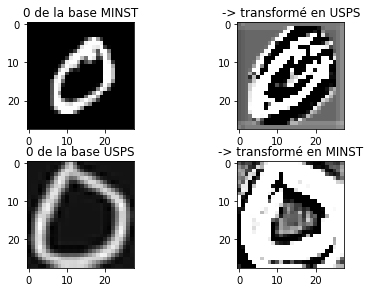

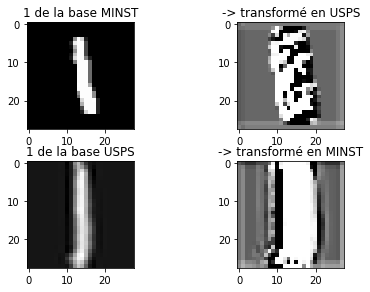

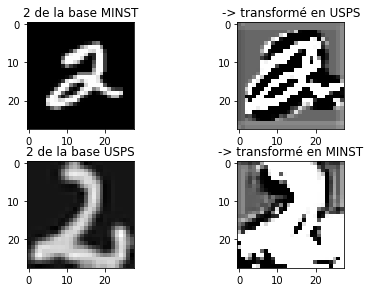

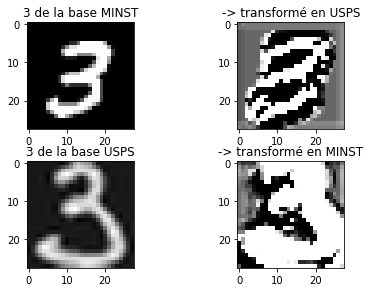

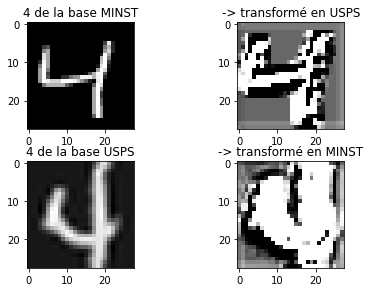

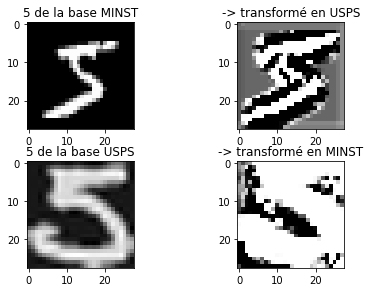

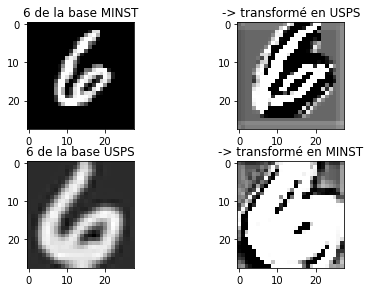

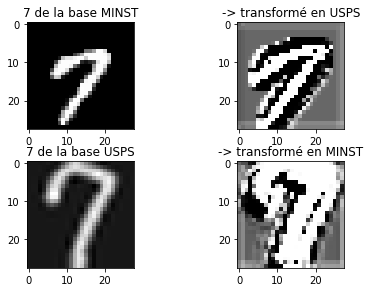

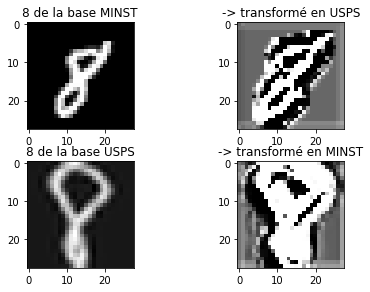

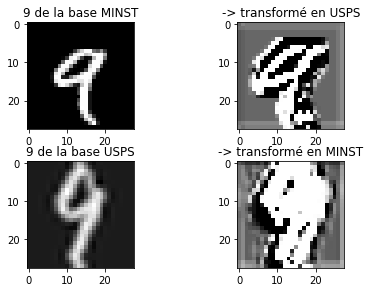

In [56]:
# Print des résultats 

##indice des chiffres à plotter
dic_index_MINST={'0':1,'1':6,'2':5,'3':7,'4':2,'5':0,'6':13,'7':15,'8':17,'9':4}
dic_index_USPS={'0':8,'1':7,'2':41,'3':4,'4':2,'5':1,'6':0,'7':3,'8':54,'9':64}
 

## Print des résultats après 200 itérations
folder_tosave='models_fonds_noir'
for number_toplot in range(10):
    print_results(folder_tosave,iteration_model_toplot=200,number_toplot=number_toplot,base_MINST=train_image_Mn,base_USPS=train_image_Up)


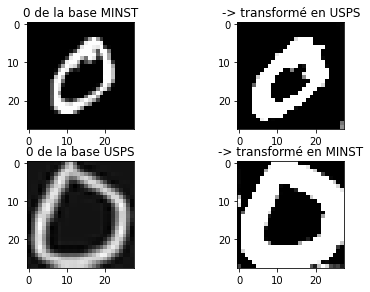

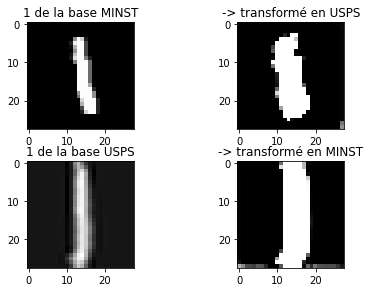

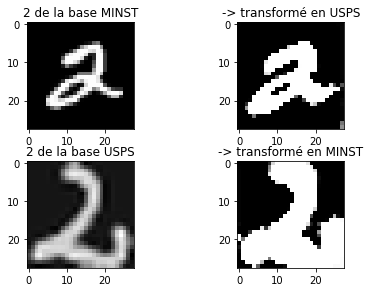

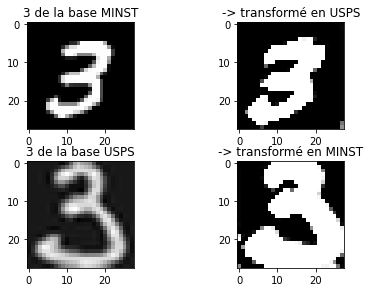

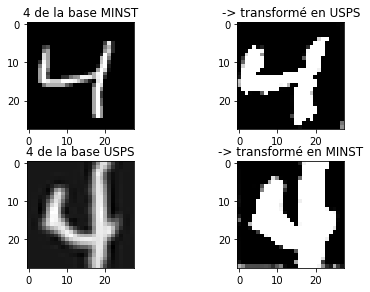

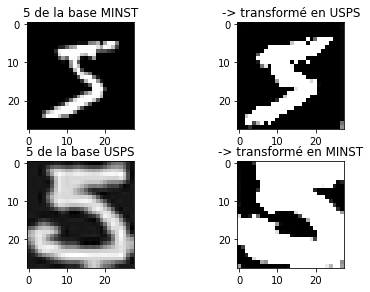

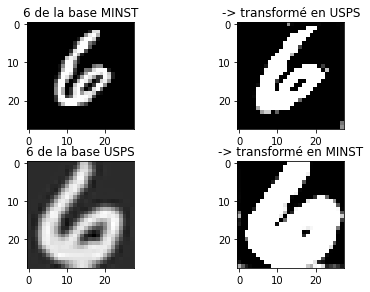

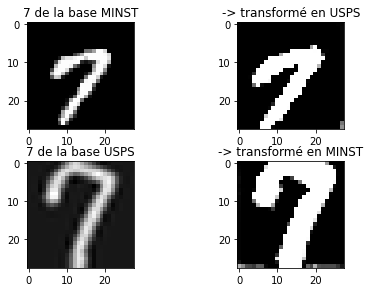

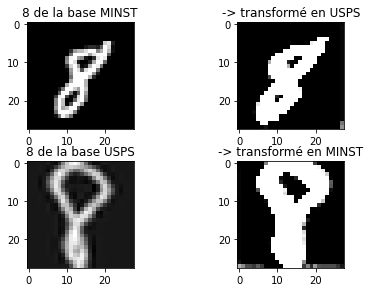

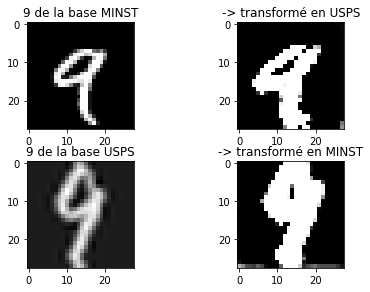

In [57]:
## Print des résultats après 1000 itérations
folder_tosave='models_fonds_noir'
for number_toplot in range(10):
    print_results(folder_tosave,iteration_model_toplot=1000,number_toplot=number_toplot,base_MINST=train_image_Mn,base_USPS=train_image_Up)

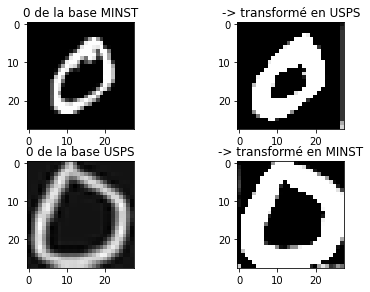

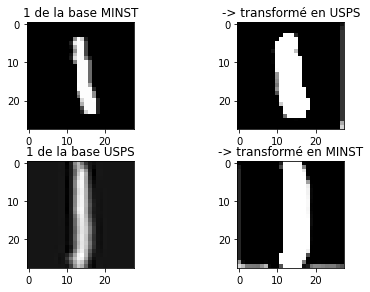

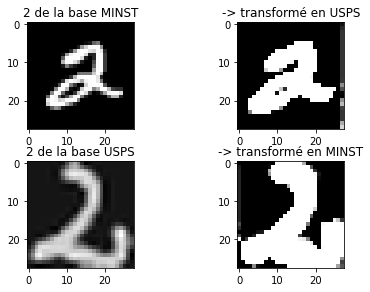

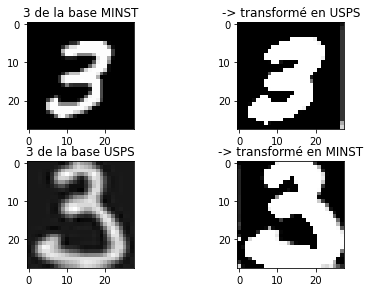

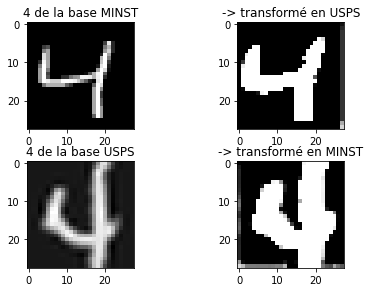

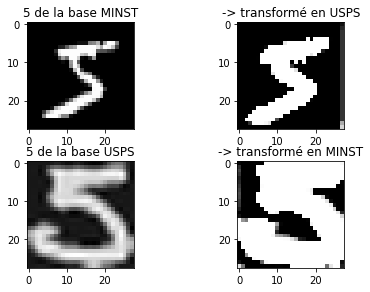

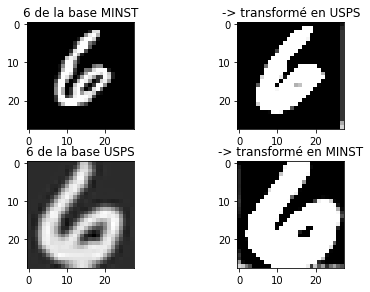

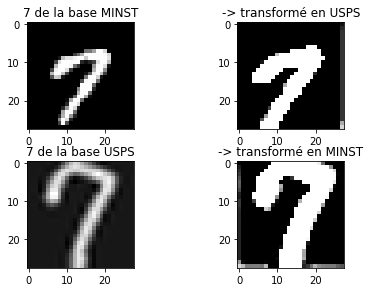

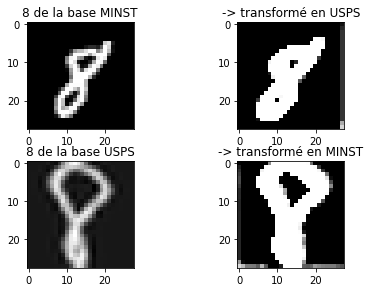

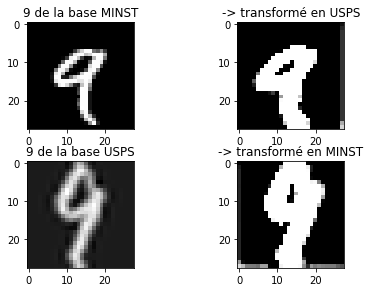

In [58]:
## Print des résultats après 5000 itérations
folder_tosave='models_fonds_noir'
for number_toplot in range(10):
    print_results(folder_tosave,iteration_model_toplot=5000,number_toplot=number_toplot,base_MINST=train_image_Mn,base_USPS=train_image_Up)

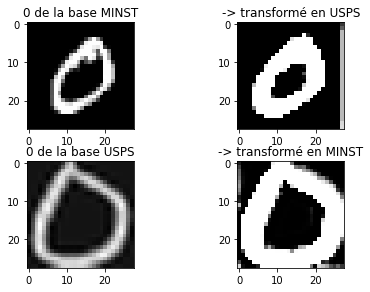

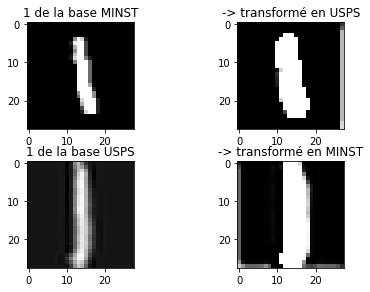

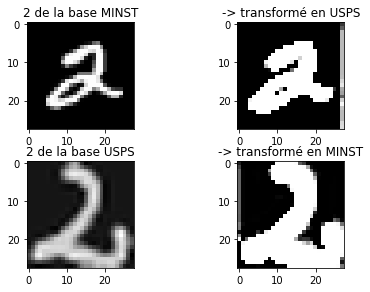

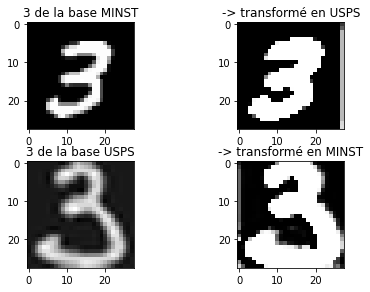

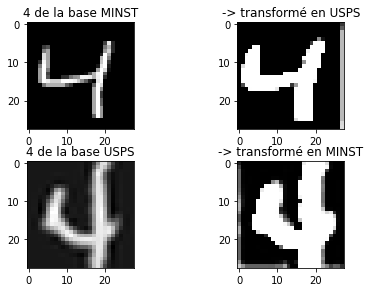

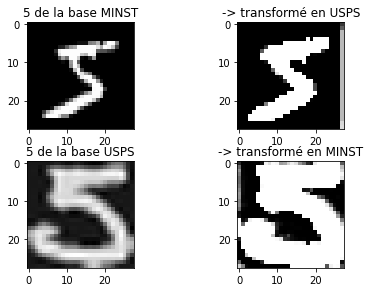

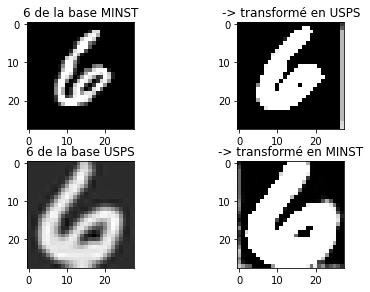

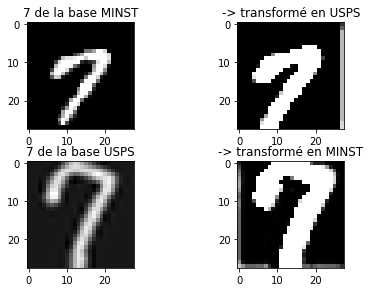

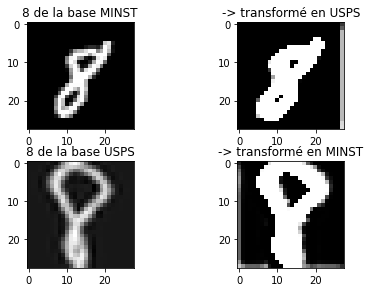

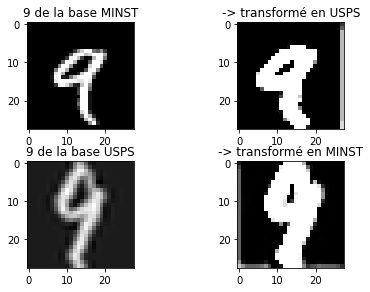

In [59]:
## Print des résultats après 10000 itérations
folder_tosave='models_fonds_noir'
for number_toplot in range(10):
    print_results(folder_tosave,iteration_model_toplot=10000,number_toplot=number_toplot,base_MINST=train_image_Mn,base_USPS=train_image_Up)

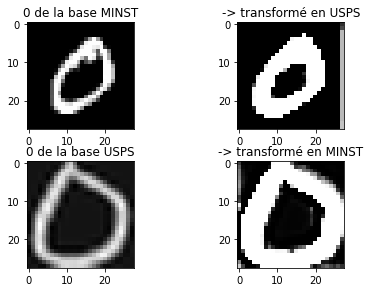

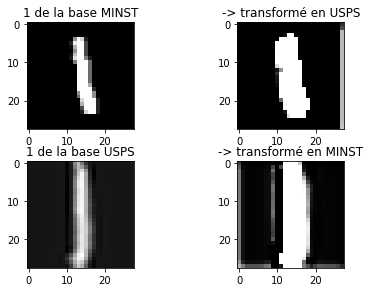

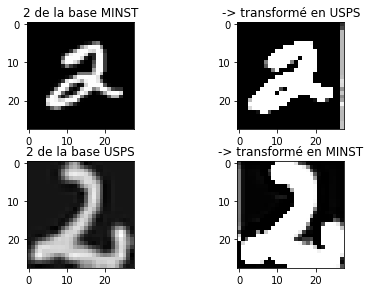

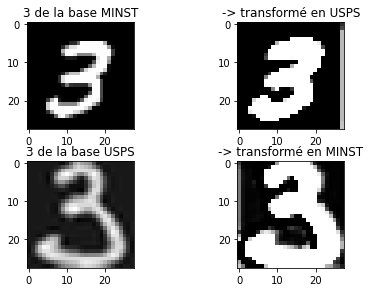

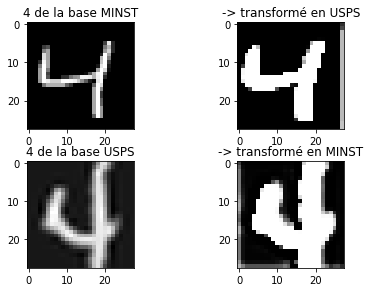

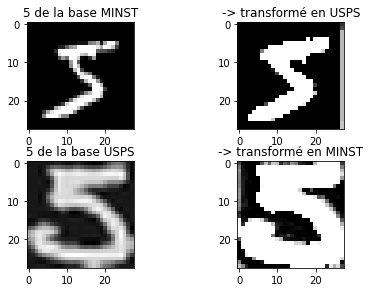

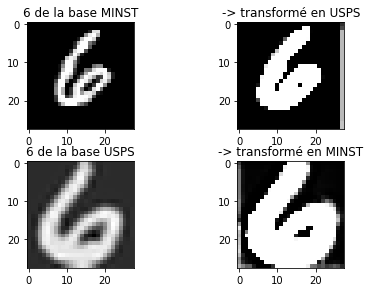

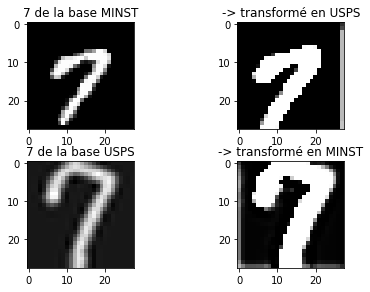

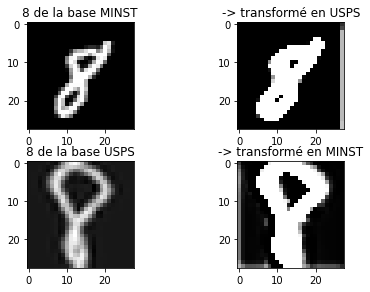

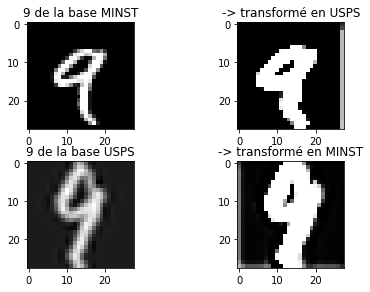

In [60]:
## Print des résultats après 15000 itérations
folder_tosave='models_fonds_noir'
for number_toplot in range(10):
    print_results(folder_tosave,iteration_model_toplot=15000,number_toplot=number_toplot,base_MINST=train_image_Mn,base_USPS=train_image_Up)

La différence de style est difficilement observable étant donné que la 'forme' est conservée et que les couleurs sont similaires. 

## 2.c CycleGan simplifié sur des images de fonds noirs et blancs

Pour observer une réelle différence, on modifie le fond des images USPS en blanc au lieu de noir. 

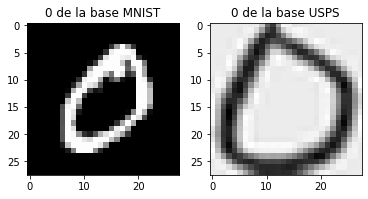

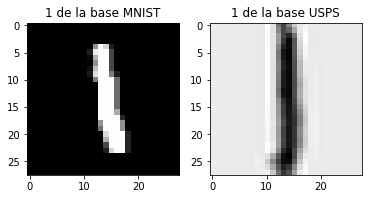

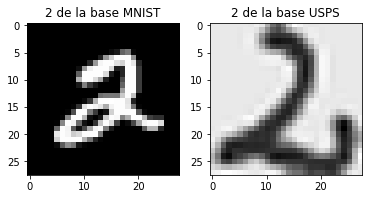

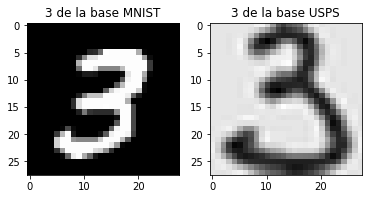

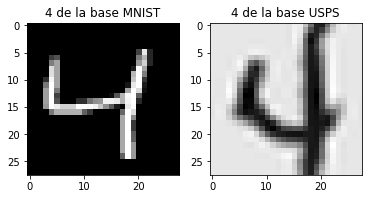

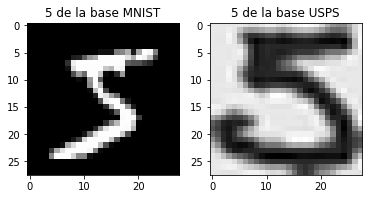

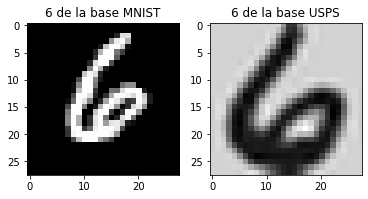

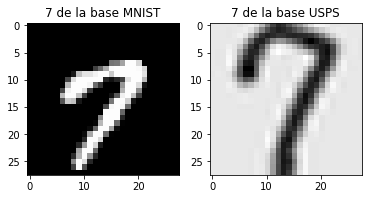

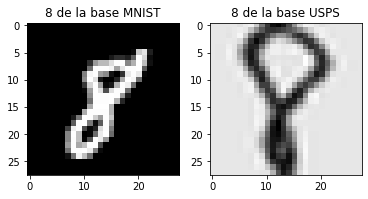

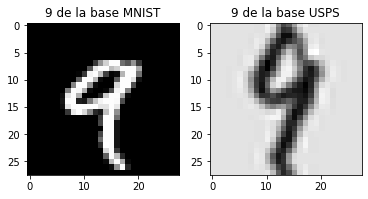

In [61]:
# Modification des bases de données 

train_image_Up_blanc=train_image_Up.copy()

for image_index in range(train_image_Up_blanc.shape[0]):
    train_image_Up_blanc[image_index]=1-train_image_Up_blanc[image_index]
    
# Visualisaton des nouvelles données 
for number_toplot in range(10):
    print_data_vize(number_toplot,train_image_Mn,train_image_Up_blanc)

In [62]:
model_ = Model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
batch_size = 200
number_iteration = 15000
lambda_ = 10
list_tosave=[200,1000,5000,10000,15000]
folder_tosave='models_fonds_noir_blanc'

# Enlever les guillement pour refaire l'apprentissage
"""
apprentissage_model(model_,train_image_Mn,train_image_Up_blanc,lambda_,number_iteration,batch_size,optimizer,list_tosave,folder_tosave)
"""

'\napprentissage_model(model_,train_image_Mn,train_image_Up_blanc,lambda_,number_iteration,batch_size,optimizer,list_tosave,folder_tosave)\n'

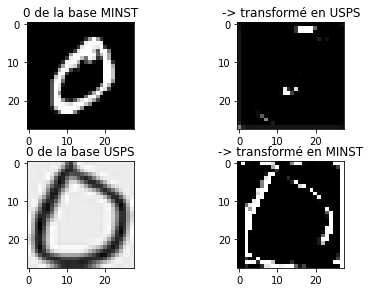

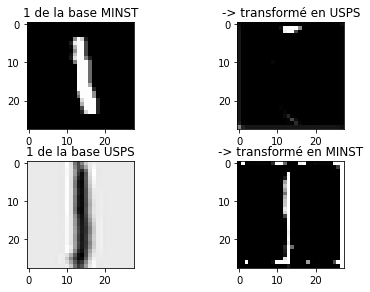

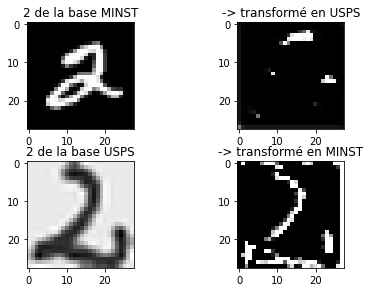

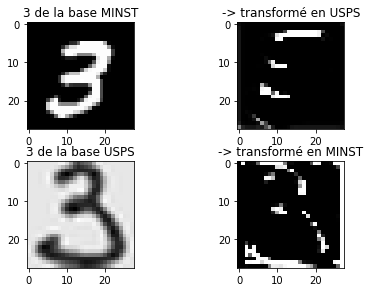

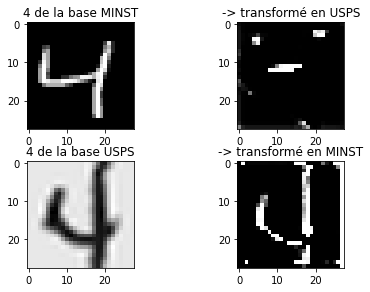

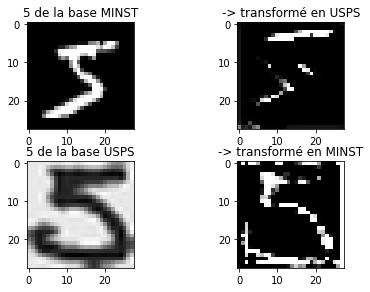

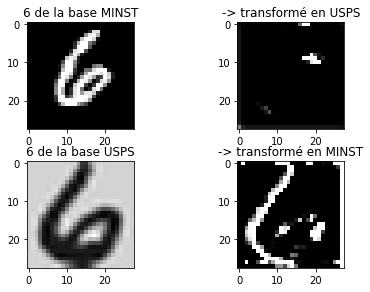

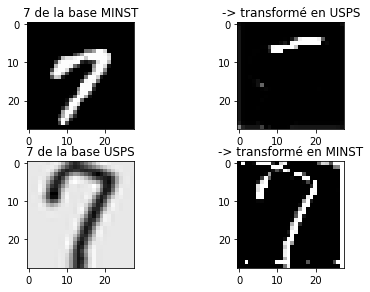

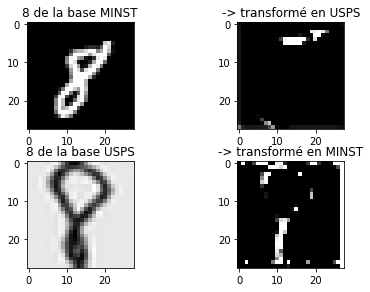

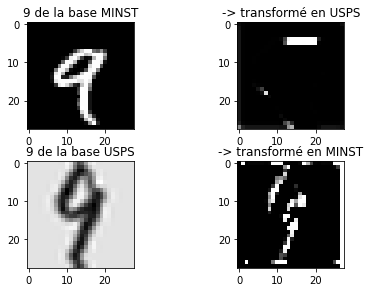

In [63]:
## Print des résultats après 200 itérations
folder_tosave='models_fonds_noir_blanc'
for number_toplot in range(10):
    print_results(folder_tosave,iteration_model_toplot=200,number_toplot=number_toplot,base_MINST=train_image_Mn,base_USPS=train_image_Up_blanc,fond=False)
    

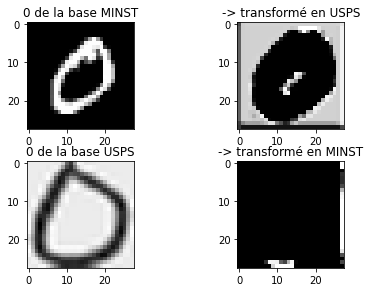

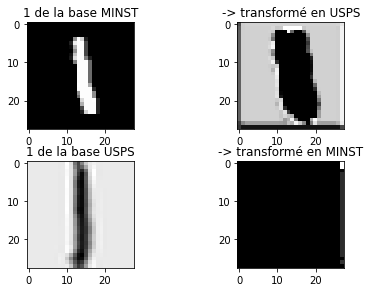

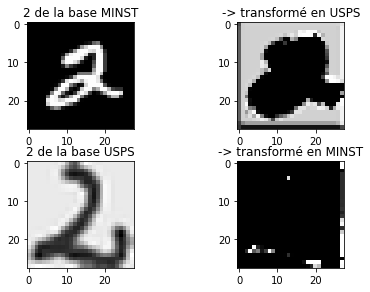

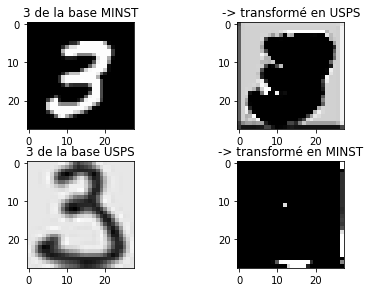

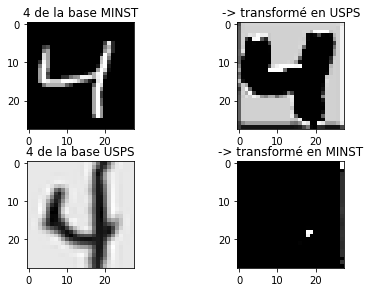

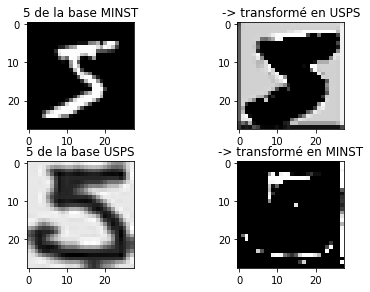

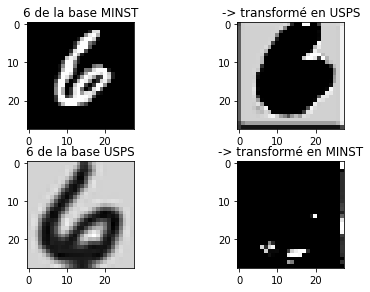

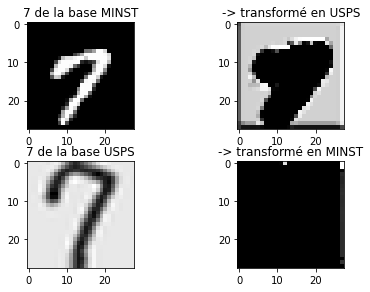

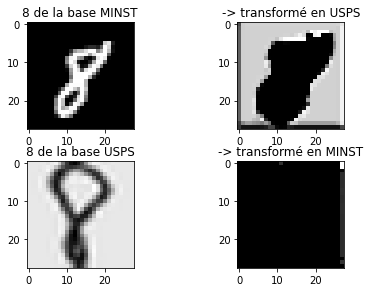

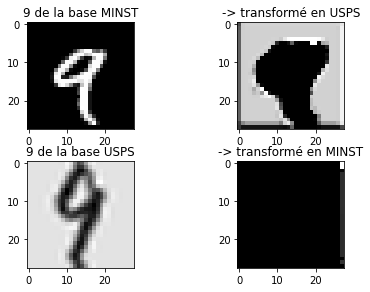

In [64]:
## Print des résultats après 1000 itérations
folder_tosave='models_fonds_noir_blanc'
for number_toplot in range(10):
    print_results(folder_tosave,iteration_model_toplot=1000,number_toplot=number_toplot,base_MINST=train_image_Mn,base_USPS=train_image_Up_blanc,fond=False)

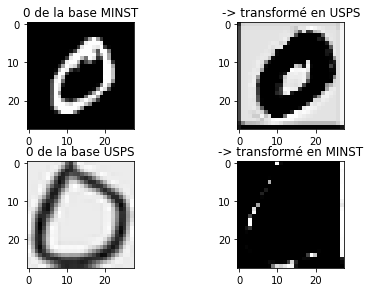

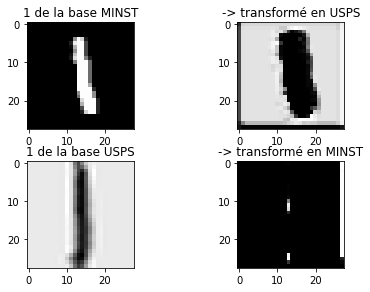

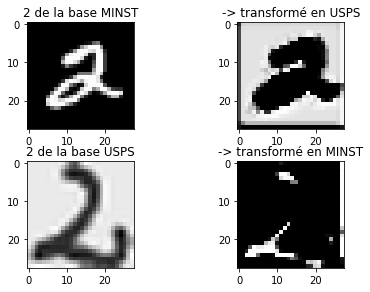

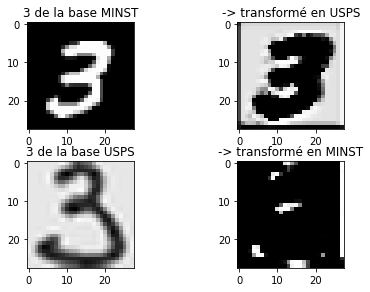

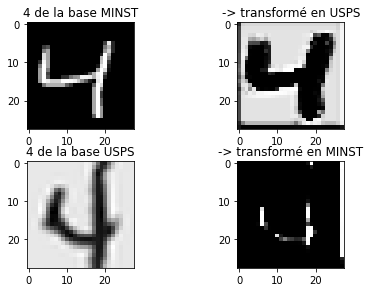

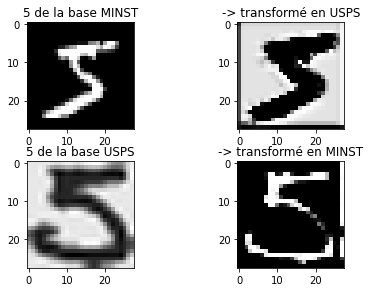

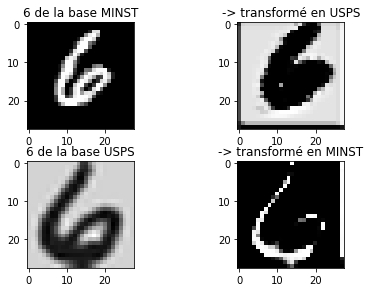

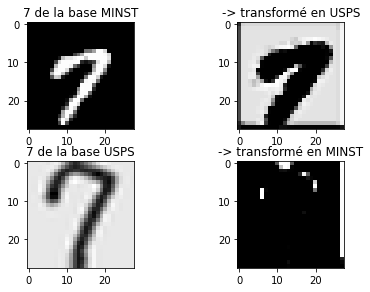

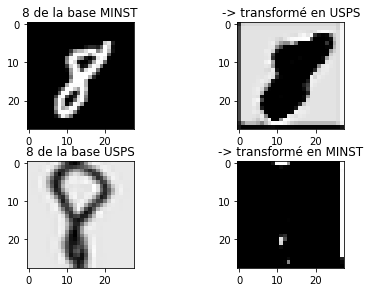

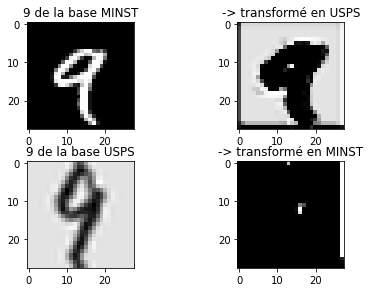

In [65]:
## Print des résultats après 5000 itérations
folder_tosave='models_fonds_noir_blanc'
for number_toplot in range(10):
    print_results(folder_tosave,iteration_model_toplot=5000,number_toplot=number_toplot,base_MINST=train_image_Mn,base_USPS=train_image_Up_blanc,fond=False)

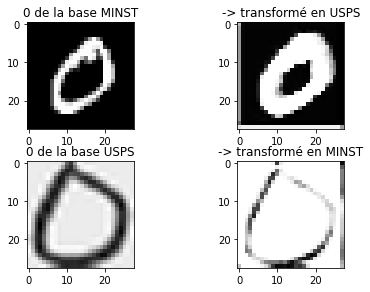

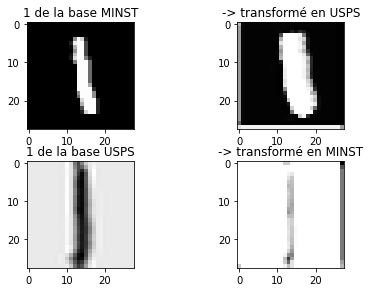

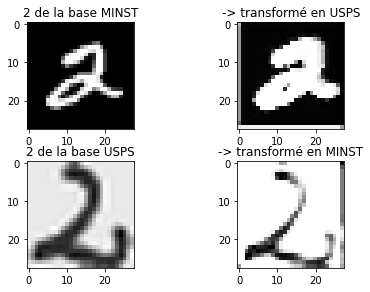

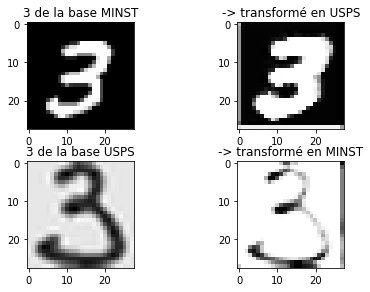

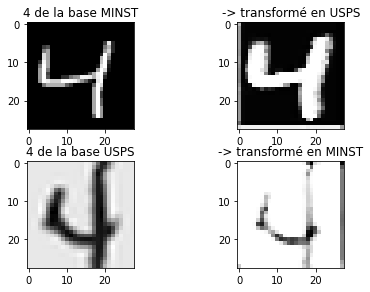

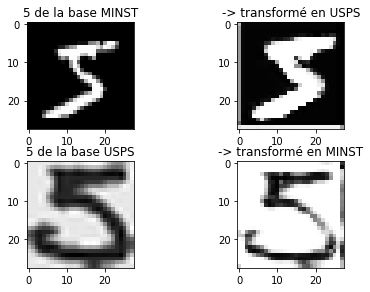

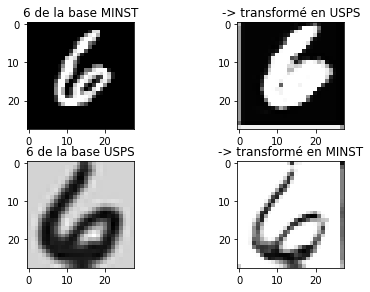

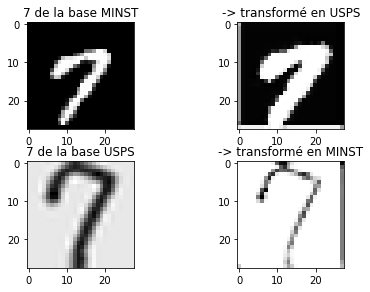

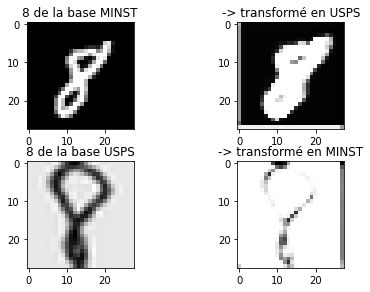

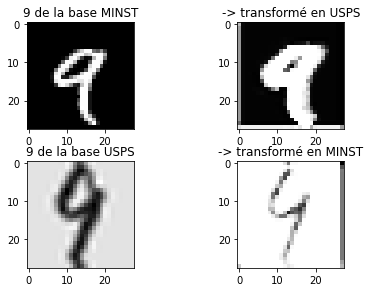

In [66]:
## Print des résultats après 10000 itérations
folder_tosave='models_fonds_noir_blanc'
for number_toplot in range(10):
    print_results(folder_tosave,iteration_model_toplot=10000,number_toplot=number_toplot,base_MINST=train_image_Mn,base_USPS=train_image_Up_blanc,fond=False)

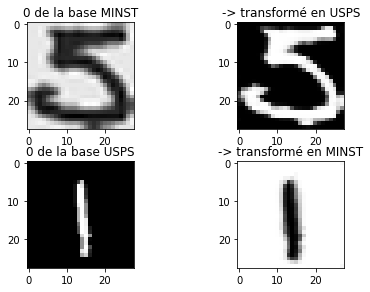

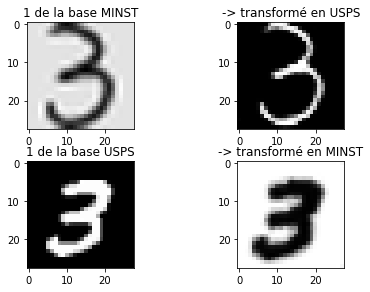

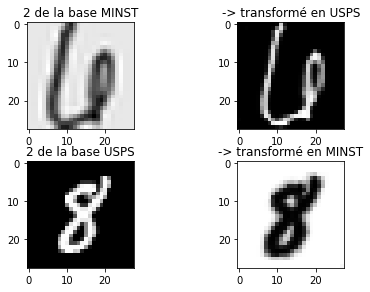

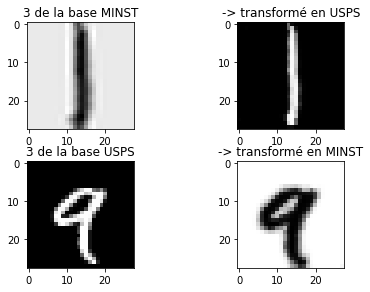

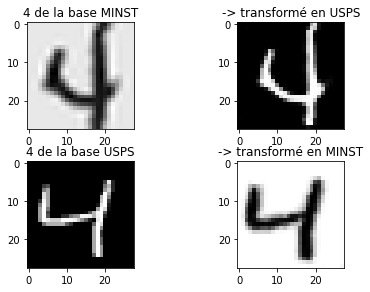

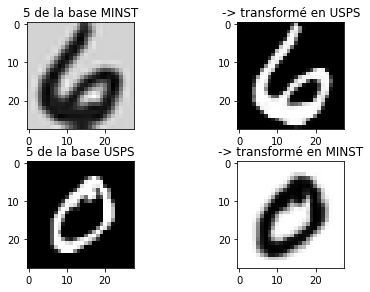

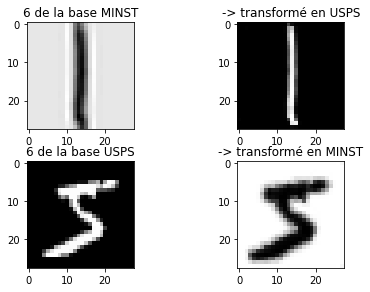

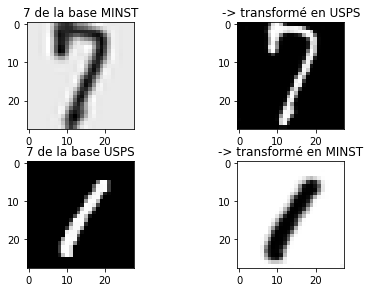

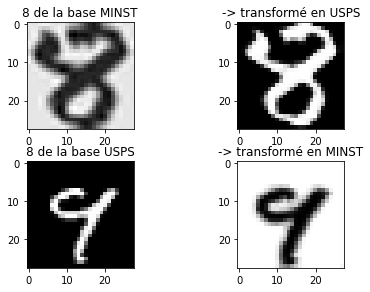

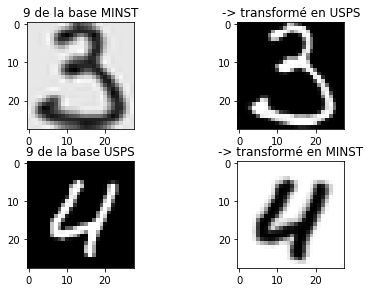

In [67]:
## Print des résultats après 15000 itérations
folder_tosave='models_fonds_noir_blanc'
for number_toplot in range(10):
    print_results(folder_tosave,iteration_model_toplot=15000,number_toplot=number_toplot,base_MINST=train_image_Up_blanc,base_USPS=train_image_Mn,fond=False)
    

Cette fois, le style a bien été transformée (noir->blanc et blanc->noir)